In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(4)

Autosaving every 600 seconds


# Neural Process 1D - Sinusoisals

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by $f(x) = a * sin(x - b) + 0.01 \epsilon$ where $a$ and $b$ and randomly sampled and $\epsilon$ is some white noise.

**Credits**: the task, visualisation and notebook structure are similar to : https://github.com/EmilienDupont/neural-processes


In [3]:
from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.training.helpers import context_target_split

from ntbks_datasets import SineDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 50
num_context = 4
num_target = 4
batch_size = 2


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=2)

def get_cntxt_trgt(*args):
    return context_target_split(*args, 
                                range_cntxts=(num_context, num_context), 
                                range_extra_trgts=(num_target, num_target))

neural_proc = NeuralProcess(x_dim, y_dim,
                            Encoder=_DeepMLP,
                            Decoder=_DeepMLP,
                            r_dim=r_dim,
                            LatentEncoder=MLP,
                            get_cntxt_trgt=get_cntxt_trgt)

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=100 and input=50. Setting it to 50.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

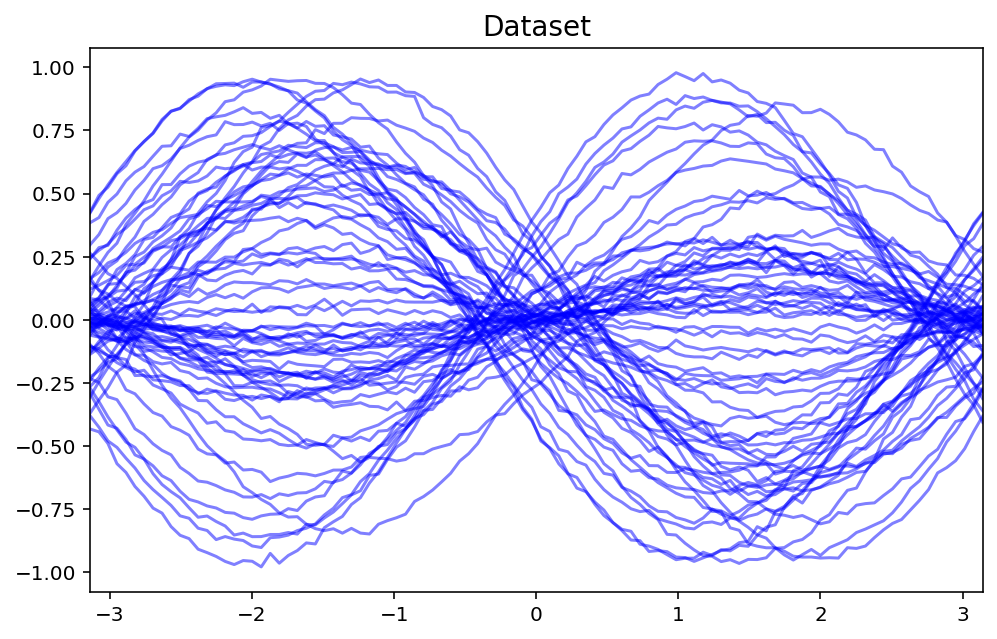

In [18]:
dataset = SineDataset(num_samples=2000)
plot_dataset_samples(dataset)

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

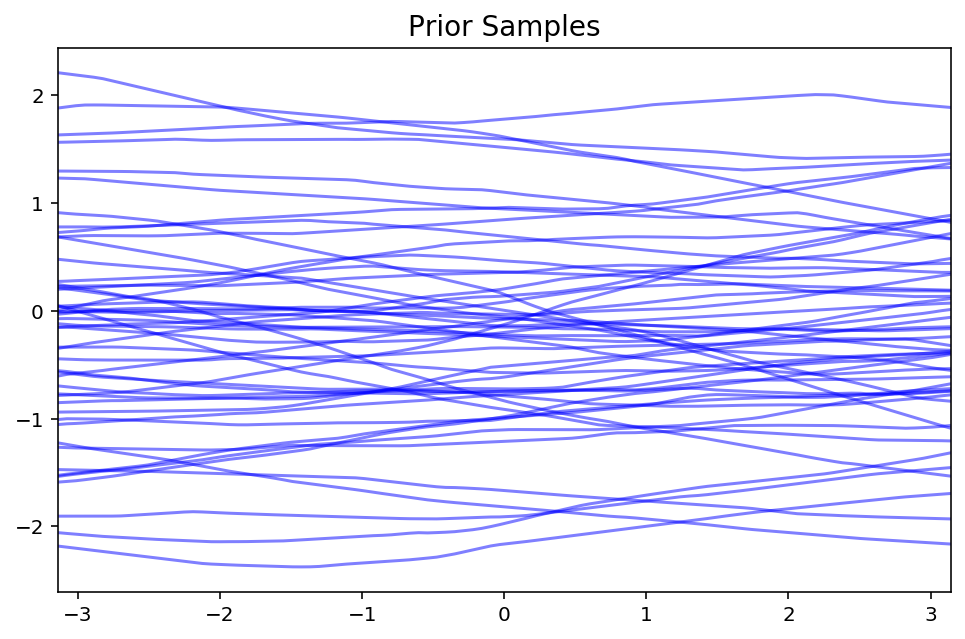

In [7]:
plot_prior_samples(neural_proc, r_dim)

## Training

In [8]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input


model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                             max_epochs=30,
                            batch_size=batch_size)

In [9]:
_=model.fit(*make_Xy_input(dataset))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.4923        2.9082  3.1133


      2        2.9477        0.7162  4.4989


      3        1.5780        0.8170  4.5088


      4        0.3544       -0.6907  4.5582


      5       -0.6218       -2.2497  4.8513


      6       -1.4601       -3.3187  4.4616


      7       -1.5764       -3.1367  4.7829


      8       -2.3345       -4.2512  4.7552


      9       -2.7488       -3.1511  3.3637


     10       -3.2235       -4.1625  4.7489


     11       -3.2797       -3.4541  4.8041


     12       -3.4061       -4.0410  4.9216


     13       -3.7764       -5.5546  4.7389


     14       -3.9672       -5.1363  4.9399


     15       -4.2363       -5.7625  4.5709


     16       -3.5443       -6.0674  4.6552


     17       -4.1502       -4.4481  4.8439


     18       -4.3132       -5.5156  4.6725


     19       -4.0262       -4.5867  4.7899


     20       -4.4560       -5.7790  4.7032


     21       -4.4139       -5.2661  4.8134


     22       -4.3203       -5.7175  4.8150


     23       -4.5975       -6.3675  4.7776


     24       -4.6255       -5.9708  4.6829


     25       -4.5303       -4.9791  4.9074


     26       -4.6816       -6.3930  4.8521


     27       -4.7082       -5.7595  4.8359


     28       -4.7657       -5.8843  4.7047


     29       -4.9214       -5.6660  4.8537


     30       -5.1242       -6.5787  5.0155


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

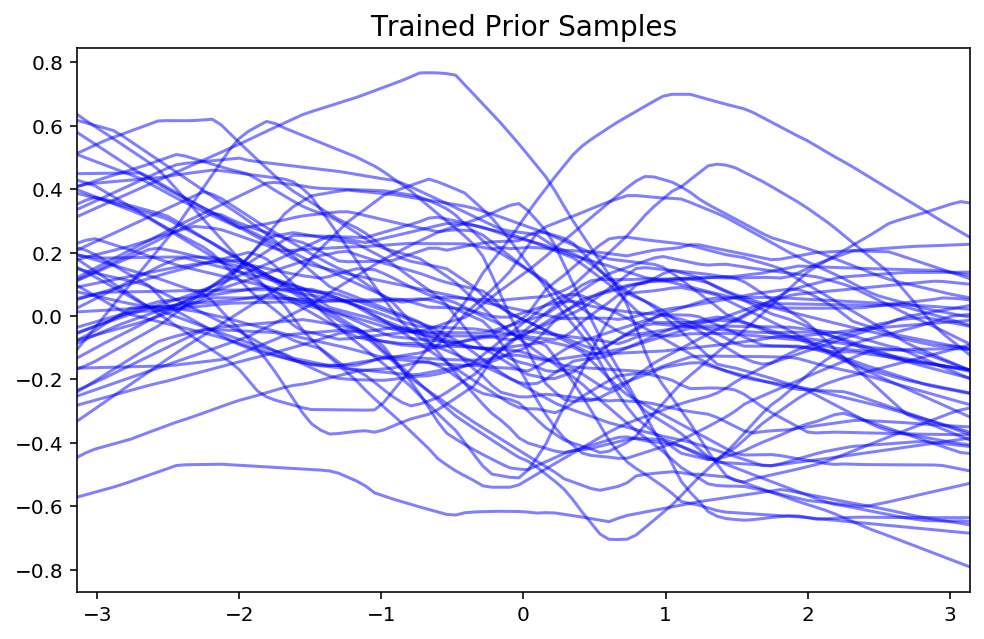

In [10]:
plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples")

## Posterior

std: 0.10139629


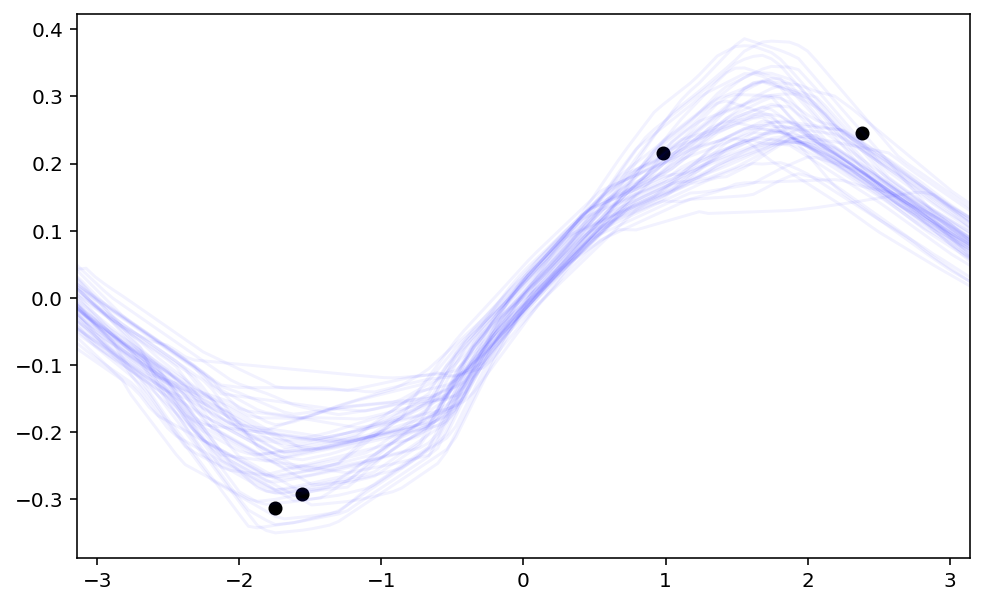

In [43]:
for X, Y in model.get_iterator(dataset, training=False):
    break
    
X_cntxt, Y_cntxt, _, _ = context_target_split(X[0:1], Y[0:1], 
                                range_cntxts=(4, 4))

plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt)

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.1272032


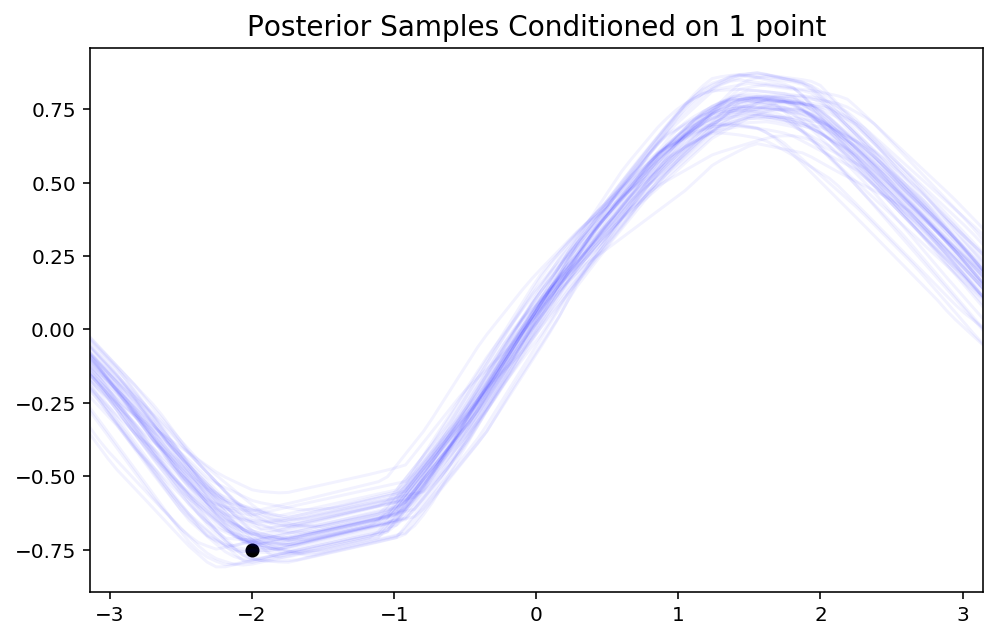

In [13]:
plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]),
                 title="Posterior Samples Conditioned on 1 point")

We see that the model is overly confident in places without context point, but this is not surprising as we trained on non noisy functions where a single point could predict the whole function. 

To see if this is the reaon of overly confidence we can test with a context point very far from the one above and see if the sampled function changes.

std: 0.13413529


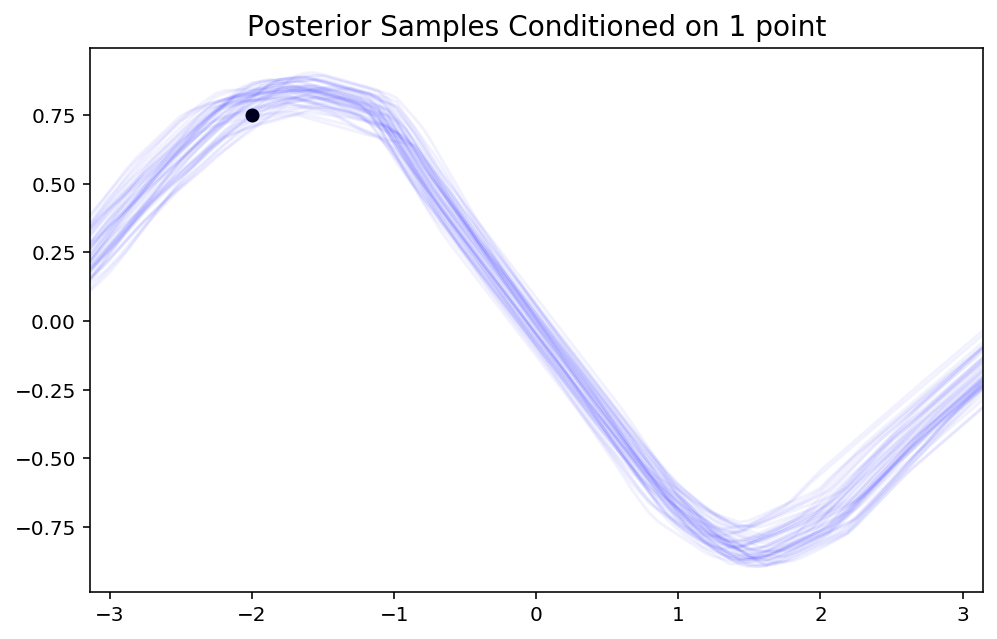

In [14]:
plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]),
                 title="Posterior Samples Conditioned on 1 point")

Indeed it does. What happens when we give a point which it has never really seen: 

std: 0.10000378


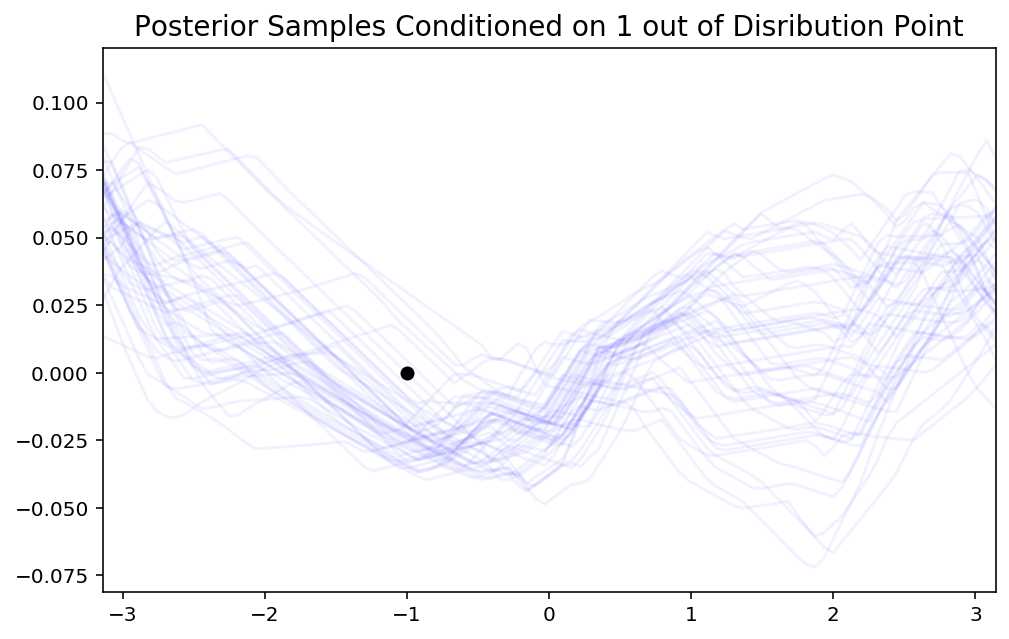

In [21]:
plot_posterior_samples(neural_proc, torch.tensor([[[-1.]]]), torch.tensor([[[-0.]]]),
                 title="Posterior Samples Conditioned on 1 out of Disribution Point")

We see that it is "lost", meaning that that the posterior variance is high, which is good.

Note that we are forcing the standard deviation of the latent z to be between 0.1 and 0.9, it is thus important to see that the predicted values don't all collapse to one of those bounds.

In [16]:
def posterior_samples(model, X_cntxt, Y_cntxt, n_samples=50, n_trgt=100, is_plot_std=False):
    """
    Plot the mean at `n_trgt` different points for `n_samples` 
    different latents (i.e. sampled functions) conditioned on cntxt points.
    """
    X_target = torch.Tensor(np.linspace(-pi, pi, n_trgt))
    X_target = X_target.unsqueeze(1).unsqueeze(0)
    
    mean_z = 0
    
    for i in range(n_samples):
        _, p_y_pred, _, q_z_trgt, _ = model.forward_step(X_cntxt, Y_cntxt, X_target)
        mean_z += q_z_trgt.base_dist.scale.detach().numpy()[0].flatten()

        X = X_target.numpy()[0].flatten()
        mean_y = p_y_pred.base_dist.loc.detach().numpy()[0].flatten()
        std_y = p_y_pred.base_dist.scale.detach().numpy()[0].flatten()

        plt.plot(X, mean_y, alpha=0.05, c='b')

        if is_plot_std:
            plt.fill_between(X, mean_y-std_y, mean_y+std_y, alpha=0.05)
        plt.xlim(-pi, pi)
    
    print("std:",mean_z/n_samples)
    plt.scatter(X_cntxt[0].numpy(), Y_cntxt[0].numpy(), c='k')